In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon as PolygonPatch
from matplotlib.animation import FuncAnimation, FFMpegWriter
from body import Cylinder
from wavegreen import FreeSurface
from wavesolver import RadiationSolver, DiffractionSolver
from twodubem._internal import tozero

In [2]:
# Parameters.
rho = 1.0  # Water density
g = 9.81   # Acceleration of gravity
R = 1.0    # Cylinder radius

wv = np.linspace(0.25, 5.0, 100)  # Frequencies
kv = wv**2 / g                   # Wavenumbers
ws = wv * np.sqrt(R / g)         # Dimensionless frequencies

# Cylinder.
number_of_elements = 10
FC = Cylinder(R, number_of_elements)
FC.add_degree_of_freedom('sway')
FC.add_degree_of_freedom('heave')
FC.set_inertia_matrix()
FC.set_stiffness_matrix()
nd = len(FC.dofs)

In [3]:
az = np.empty((len(wv), nd, nd))                   # Added mass
bz = np.empty((len(wv), nd, nd))                   # Wave damping
wa = np.empty((len(wv), nd))                       # Radiated wave amplitude ratio
fz = np.empty((len(wv), nd), dtype=np.complex128)  # Exciting force
za = np.empty((len(wv), nd), dtype=np.complex128)  # Body's response
kr = np.empty(len(wv))                             # Reflection coefficient
kt = np.empty(len(wv))                             # Transmission coefficient

for i, w in enumerate(wv):
    k = w**2 / g
    L = 2*np.pi / k
    
    FS = FreeSurface(w, FC)
    rsolver = RadiationSolver(FC, FS)
    dsolver = DiffractionSolver(FC, FS)
    rsolver.solve()
    dsolver.solve()

    rsolver.compute_radiation_coefficients()
    dsolver.compute_exciting_forces()
    
    az[i] = rsolver.added_mass
    bz[i] = rsolver.radiation_damping
    fz[i] = dsolver.force
    za[i] = np.linalg.solve((-w**2*(FC.M+az[i]) - 1j*w*bz[i] + FC.C), fz[i])

    # Compute radiated wave amplitude ratio.
    phir, _, = rsolver.get_solution(np.array([2.0*L]), np.array([0.0]))
    wa[i] = np.abs(1j * phir[0]) * w / g
    
    # Compute reflection and transmission coefficients.
    fsp = np.array([[-2.0*L, 0.0], [2.0*L, 0.0]])

    phir, _ = rsolver.get_solution(fsp[:, 0], fsp[:, 1])
    phid, _ = dsolver.get_solution(fsp[:, 0], fsp[:, 1])
    phi0, _ = dsolver.incident_wave_potential(fsp[:, 0], fsp[:, 1], w, g)

    kr[i] = np.abs((np.sum(za[i]*phir[0]) + phid[0]) / phi0[0])
    kt[i] = np.abs((np.sum(za[i]*phir[1]) + phid[1] + phi0[1]) / phi0[1])

In [4]:
# Parameters for making results dimensionless.
m = FC.M[1, 1]  # Cylinder mass
c = FC.C[1, 1]  # Restoring coefficient in heave

# Dimensionless radiation coefficients.
azn = az / m
bzn = bz * np.sqrt(R/g) / m

# Dimensionless force.
fzn = np.abs(fz)
fzn[:, 0] = np.abs(fz[:, 0]) / (m * g * kv)
fzn[:, 1] = np.abs(fz[:, 1]) / c

# Response Amplitude Operator and phase.
zrao = np.abs(za)
zeps = np.atan2(za.imag, za.real)

# This should add up to 1. I won't be exactly one,
# specially for high frequencies, due to lack of
# mesh refinement.
ks = kr**2 + kt**2

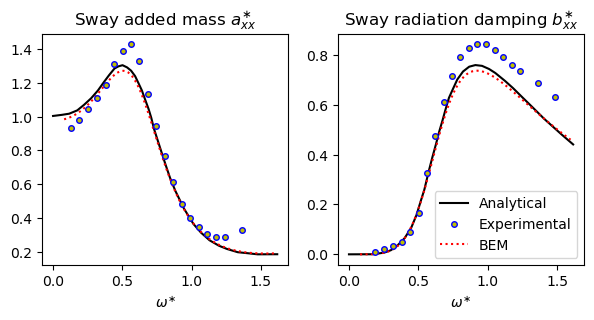

In [5]:
axx_analytical = np.loadtxt('references/axx_analytical.csv', delimiter=',')
axx_experimental = np.loadtxt('references/axx_experimental.csv', delimiter=',')
bxx_analytical = np.loadtxt('references/bxx_analytical.csv', delimiter=',')
bxx_experimental = np.loadtxt('references/bxx_experimental.csv', delimiter=',')

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].set_title(r'Sway added mass $a^{\ast}_{xx}$')
ax[0].set_xlabel(r'$\omega^{\ast}$')

ax[0].plot(axx_analytical[:, 0], axx_analytical[:, 1], '-k', label='Analytical')
ax[0].plot(ws, azn[:, 0, 0], ':r', label='BEM')
ax[0].plot(axx_experimental[:, 0], axx_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

ax[1].set_title(r'Sway radiation damping $b^{\ast}_{xx}$')
ax[1].set_xlabel(r'$\omega^{\ast}$')

ax[1].plot(bxx_analytical[:, 0], bxx_analytical[:, 1], '-k', label='Analytical')
ax[1].plot(ws, bzn[:, 0, 0], ':r', label='BEM')
ax[1].plot(bxx_experimental[:, 0], bxx_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax[1].legend(by_label.values(), by_label.keys())

plt.savefig('radiation_coefs_sway.svg', bbox_inches='tight')
plt.show()

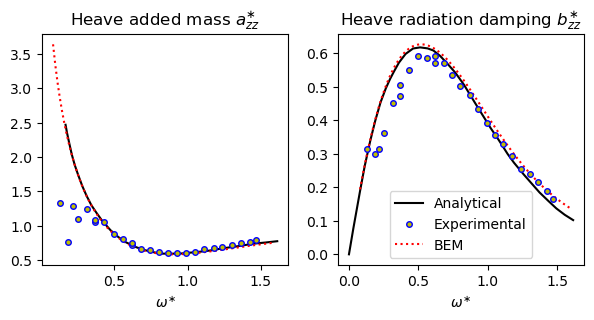

In [6]:
azz_analytical = np.loadtxt('references/azz_analytical.csv', delimiter=',')
azz_experimental = np.loadtxt('references/azz_experimental.csv', delimiter=',')
bzz_analytical = np.loadtxt('references/bzz_analytical.csv', delimiter=',')
bzz_experimental = np.loadtxt('references/bzz_experimental.csv', delimiter=',')

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].set_title(r'Heave added mass $a^{\ast}_{zz}$')
ax[0].set_xlabel(r'$\omega^{\ast}$')

ax[0].plot(azz_analytical[:, 0], azz_analytical[:, 1], '-k', label='Analytical')
ax[0].plot(ws, azn[:, 1, 1], ':r', label='BEM')
ax[0].plot(azz_experimental[:, 0], azz_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

ax[1].set_title(r'Heave radiation damping $b^{\ast}_{zz}$')
ax[1].set_xlabel(r'$\omega^{\ast}$')

ax[1].plot(bzz_analytical[:, 0], bzz_analytical[:, 1], '-k', label='Analytical')
ax[1].plot(ws, bzn[:, 1, 1], ':r', label='BEM')
ax[1].plot(bzz_experimental[:, 0], bzz_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax[1].legend(by_label.values(), by_label.keys())

plt.savefig('radiation_coefs_heave.svg', bbox_inches='tight')
plt.show()

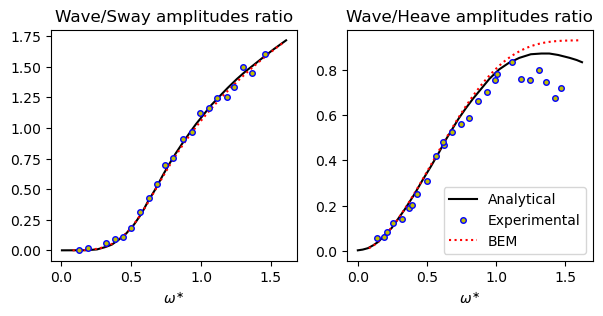

In [7]:
wx_analytical = np.loadtxt('references/wx_analytical.csv', delimiter=',')
wx_experimental = np.loadtxt('references/wx_experimental.csv', delimiter=',')
wz_analytical = np.loadtxt('references/wz_analytical.csv', delimiter=',')
wz_experimental = np.loadtxt('references/wz_experimental.csv', delimiter=',')

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].set_title(r'Wave/Sway amplitudes ratio')
ax[0].set_xlabel(r'$\omega^{\ast}$')

ax[0].plot(wx_analytical[:, 0], wx_analytical[:, 1], '-k', label='Analytical')
ax[0].plot(ws, wa[:, 0], ':r', label='BEM')
ax[0].plot(wx_experimental[:, 0], wx_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

ax[1].set_title(r'Wave/Heave amplitudes ratio')
ax[1].set_xlabel(r'$\omega^{\ast}$')

ax[1].plot(wz_analytical[:, 0], wz_analytical[:, 1], '-k', label='Analytical')
ax[1].plot(ws, wa[:, 1], ':r', label='BEM')
ax[1].plot(wz_experimental[:, 0], wz_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax[1].legend(by_label.values(), by_label.keys())

plt.savefig('radiated_wave_amplitude.svg', bbox_inches='tight')
plt.show()

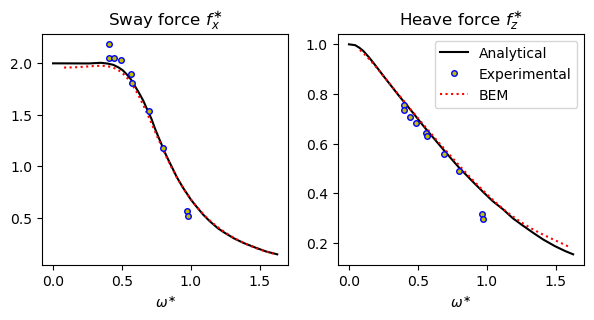

In [8]:
fx_analytical = np.loadtxt('references/fx_analytical.csv', delimiter=',')
fx_experimental = np.loadtxt('references/fx_experimental.csv', delimiter=',')
fz_analytical = np.loadtxt('references/fz_analytical.csv', delimiter=',')
fz_experimental = np.loadtxt('references/fz_experimental.csv', delimiter=',')

fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].set_title(r'Sway force $f^{\ast}_x$')
ax[0].set_xlabel(r'$\omega^{\ast}$')

ax[0].plot(fx_analytical[:, 0], fx_analytical[:, 1], '-k', label='Analytical')
ax[0].plot(ws, fzn[:, 0], ':r', label='BEM')
ax[0].plot(fx_experimental[:, 0], fx_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

ax[1].set_title(r'Heave force $f^{\ast}_z$')
ax[1].set_xlabel(r'$\omega^{\ast}$')

ax[1].plot(fz_analytical[:, 0], fz_analytical[:, 1], '-k', label='Analytical')
ax[1].plot(ws, fzn[:, 1], ':r', label='BEM')
ax[1].plot(fz_experimental[:, 0], fz_experimental[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Experimental')

handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax[1].legend(by_label.values(), by_label.keys())

plt.savefig('exciting_forces.svg', bbox_inches='tight')
plt.show()

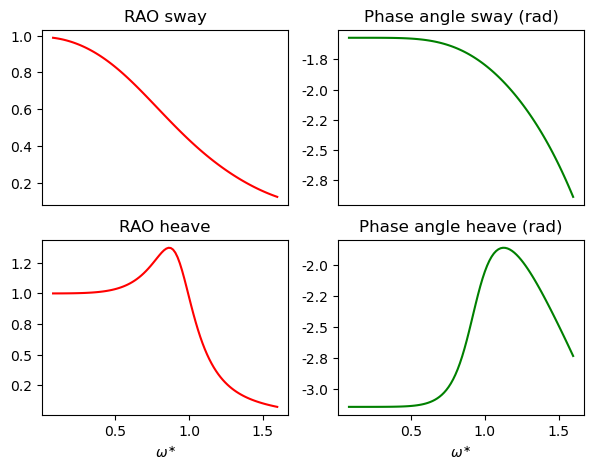

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(7, 5))

ax[0, 0].xaxis.set_visible(False)
ax[0, 1].xaxis.set_visible(False)

ax[0, 0].set_title('RAO sway')
ax[0, 0].plot(ws, zrao[:, 0], '-r')

ax[0, 1].set_title('Phase angle sway (rad)')
ax[0, 1].plot(ws, zeps[:, 0], '-g')

ax[1, 0].set_title('RAO heave')
ax[1, 0].plot(ws, zrao[:, 1], '-r')
ax[1, 0].set_xlabel(r'$\omega^{\ast}$')

ax[1, 1].set_title('Phase angle heave (rad)')
ax[1, 1].plot(ws, zeps[:, 1], '-g')
ax[1, 1].set_xlabel(r'$\omega^{\ast}$')

for ex in ax.ravel():
    ex.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

plt.savefig('RAO.svg', bbox_inches='tight')
plt.show()

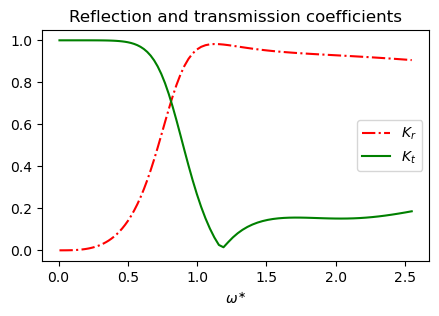

In [10]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title('Reflection and transmission coefficients')
ax.set_xlabel(r'$\omega^{\ast}$')

ax.plot(ws**2, kr, '-.r', label=r'$K_r$')
ax.plot(ws**2, kt, '-g', label=r'$K_t$')

ax.legend()

plt.savefig('wave_coefficients.svg', bbox_inches='tight')
plt.show()

In [11]:
# Choosing a frequency for the animations.
wm_index = np.where(zrao == zrao.max())[0][0]  # Maximum RAO.
# wm_index = np.where(kr == kr.max())[0][0]  # Maximum wave reflection.
wm = wv[wm_index]
Tm = 2*np.pi/wm
aw = 0.10  # Wave amplitude.
t = np.linspace(0.0, 5*Tm, 100)
et = np.exp(1j * wm * t)

FS = FreeSurface(wm, FC)
rsolver = RadiationSolver(FC, FS)
dsolver = DiffractionSolver(FC, FS)
rsolver.solve()
dsolver.solve()

fsp = np.vstack((np.linspace([-5*R, 0.0], [-R, 0.0], 30),
                 np.linspace([R, 0.0], [5*R, 0.0], 30)))

phir, _ = rsolver.get_solution(fsp[:, 0], fsp[:, 1])
phid, _ = dsolver.get_solution(fsp[:, 0], fsp[:, 1])
phi0, _ = dsolver.incident_wave_potential(fsp[:, 0], fsp[:, 1], wm, g)

fsz = 1j*aw*(np.sum(za[wm_index]*phir, axis=1) + phid + phi0) * wm / g

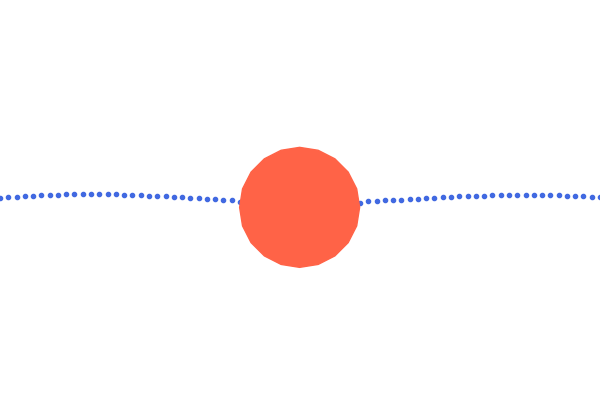

In [12]:
%matplotlib ipympl

def wave_cylinder(time_step):
    # update free surface.
    free_surface.set_ydata(np.real(fsz * et[time_step]))

    # update cylinder.
    vertices = cylinder_vertices.copy()
    vertices[:, 0] += np.real(aw * za[wm_index, 0] * et[time_step])
    vertices[:, 1] += np.real(aw * za[wm_index, 1] * et[time_step])
    cylinder.set_xy(vertices)


# Cylinder vertices.
theta = np.linspace(0.0, 2*np.pi, 2*number_of_elements + 1)
cylinder_vertices = tozero(np.column_stack((R * np.cos(theta), R * np.sin(theta))))

fig, ax = plt.subplots(figsize=(6,4), frameon=False)

# Parameters for framing the animation.
xmax = 5*R
ymax = 2*R
xmin = -xmax
ymin = -ymax

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.spines[:].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect('equal')

# Initialization.
free_surface = ax.plot(fsp[:, 0], np.real(fsz * et[0]), ls='', marker='.', color='royalblue')[0]

vertices = cylinder_vertices.copy()
vertices[:, 0] += np.real(aw * za[wm_index, 0] * et[0])
vertices[:, 1] += np.real(aw * za[wm_index, 1] * et[0])

cpatch = PolygonPatch(vertices, color='tomato', zorder=3)
cylinder = ax.add_patch(cpatch)

anim = FuncAnimation(fig, wave_cylinder, frames=range(1, len(t)), interval=100, blit=True)

# Saving to video.
fig.tight_layout(pad=0)
metadata = dict(title='floating_cylinder', artist='Rodrigo Castro')
writer = FFMpegWriter(fps=10, metadata=metadata)
anim.save('cylinder1.gif', writer=writer)

plt.show()